In [68]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
import colorcet as cc
from importlib import reload


Text(0, 0.5, '$N$')

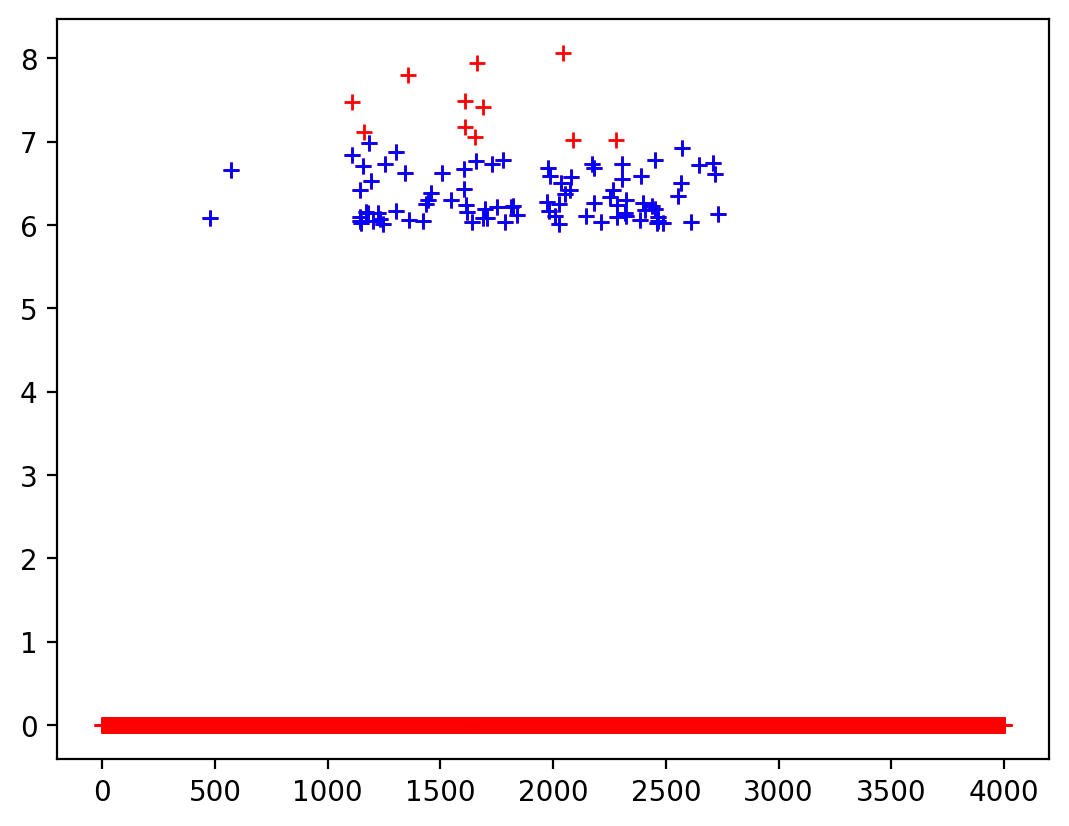

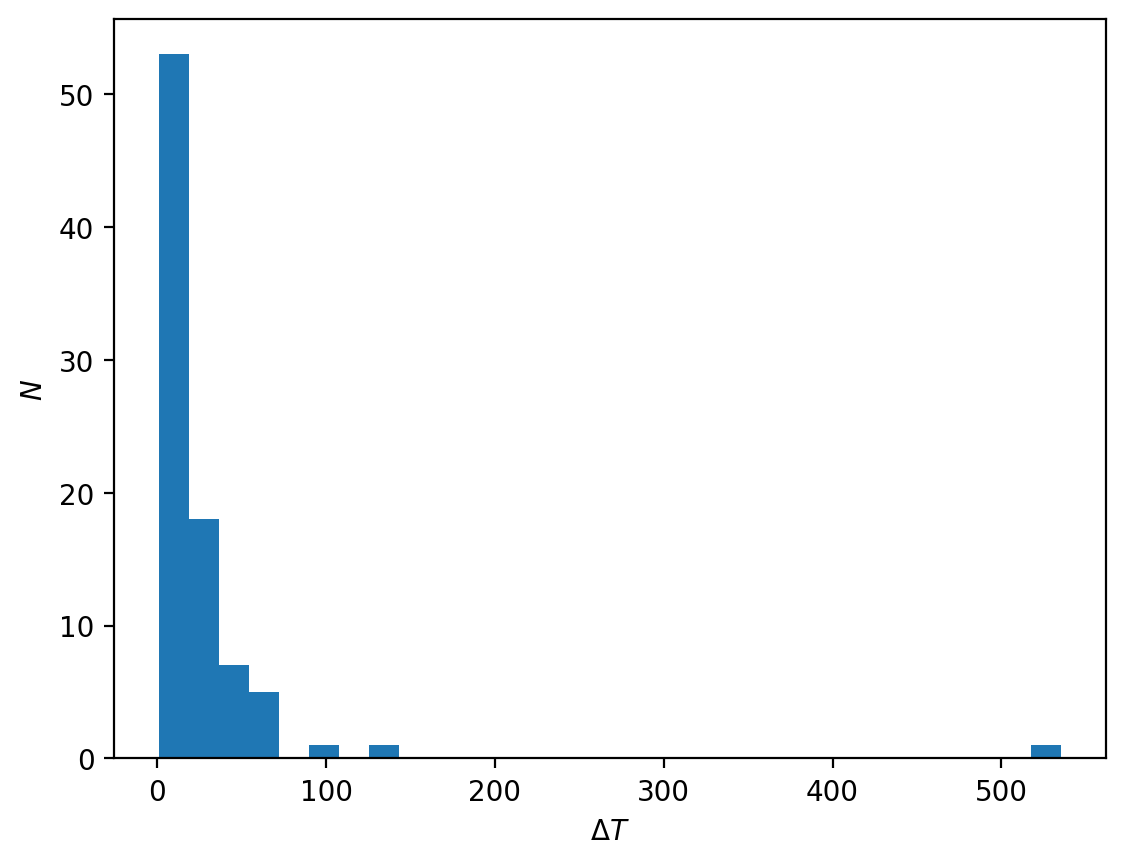

In [72]:
def get_most_recent_output_folder_name():
    most_recent_output_folder_name = sorted(glob.glob("./runs/*"))[-2]
    return most_recent_output_folder_name


most_recent_output_folder_name = get_most_recent_output_folder_name()
time_series = pickle.load(
    open(most_recent_output_folder_name + "/time_series.pickle", "rb")
)

plt.plot(time_series.time, time_series.event_magnitude, "r+")
lower_indices = np.where(time_series.event_magnitude >= 6.0)
upper_indices = np.where(time_series.event_magnitude < 7.0)
a = np.intersect1d(lower_indices, upper_indices)
plt.plot(time_series.time[a], time_series.event_magnitude[a], "b+")


# Calculate interevent times
plt.figure()
plt.hist(np.diff(time_series.time[a]), 30)
plt.xlabel("$\Delta T$")
plt.ylabel("$N$")




In [71]:
time_series.keys()


dict_keys(['time', 'probability_weight', 'probability', 'event_magnitude', 'event_trigger_flag', 'last_event_time', 'omori_history_effect'])